### Import

In [569]:
import numpy as np #добавление больших многомерных массивов и матриц и операций над ними
import random as rnd #добавление генерации случайных чисел
import matplotlib.pyplot as plt #добавление интерфейса для построения графиков простых функций
%matplotlib inline 
#построение графика непосредственно в Jupiter

from sklearn.model_selection import train_test_split #разделение датасета на train и test
from sklearn.metrics import accuracy_score, precision_score, recall_score #метрики качества

import os #взаимодействие между пользователем и операционной системой, работа с файлами и каталогами

### Dataset

In [570]:
def load_planar_dataset(m=400):
    np.random.seed(1)
    N = int(m/2)
    D = 2
    X = np.zeros((m,D))
    Y = np.zeros((m,1), dtype='uint8')
    a = 4 

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j

    return X, Y

In [571]:
def plot_decision_boundary(model, X, y):
    X = X.T
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
    plt.show()

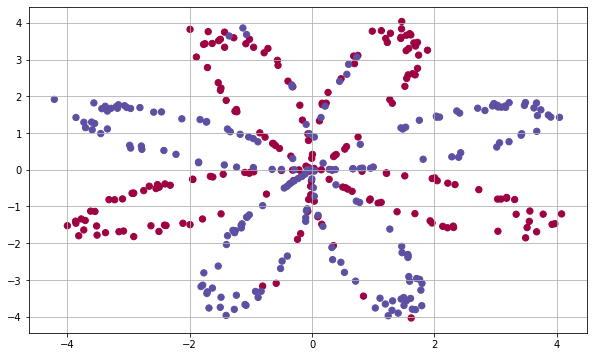

In [572]:
X, Y = load_planar_dataset() #загружаем датасет
plt.figure(figsize=(10,6))
plt.grid()
plt.scatter(X[:,0], X[:,1], c=Y[:,0], s=40, cmap=plt.cm.Spectral)

### Forward Propagation, Backward Propagation

#### Forward Propagation
Первый слой:
$$Z^{[1]} = XW^{[1]T} + b^{[1]}$$
$$A^{[1]} = \sigma^{[1]}(Z^{[1]})$$
Внутренние слои:
$$Z^{[i]} = A^{[i - 1]}W^{[i + 1]T} + b^{[i]}$$
$$A^{[i]} = \sigma^{[i]}(Z^{[i]})$$
Последний слой:
$$Z^{[n + 1]} = A^{[n]}W^{[n + 1]T} + b^{[n + 1]}$$
$$\hat{y} = sigmoid(Z^{[n + 1]})$$

#### Backward Propagation
$\vec{e}$ - столбец единиц

Последний слой:
$$dZ^{[n + 1]} = dL * (\hat{y} (1 - \hat y))$$
$$dW^{[n + 1]} = dL^{T}\cdot A^{[n]}$$
$$db^{[n + 1]} = dL^{T}\cdot \vec{e}$$
Внутренние слои:
$$dZ^{[i]} = (dZ^{[i + 1]T}\cdot W^{[i + 1]}) * \frac{\partial A^{[i]}}{\partial Z^{[i]}}$$
$$dW^{[i]} = dZ^{[i]T}\cdot A^{[i - 1]}$$
$$db^{[i]} = dZ^{[i]T}\cdot \vec{e}$$
Первый слой:
$$dZ^{[1]} = (dZ^{[2]T}\cdot W^{[2]}) * \frac{\partial A^{[1]}}{\partial Z^{[1]}}$$
$$dW^{[1]} = dZ^{[1]T}\cdot X$$
$$db^{[1]} = dZ^{[1]T}\cdot \vec{e}$$

### Class NeuralNetwork

In [573]:
class NeuralNetwork:
    
    def __init__(self, n_input, data):
        self.data = data            #информация о нейросети
        self.nl = len(data)         #количество слоёв
        self.ni = n_input           #количество вводных данных
        self.size_layers = dict()   #словарь, содержащий размеры слоёв
        self.funcs = dict()         #словарь функций активации для каждого слоя
        self.funcs_der = dict()     #словарб производных функций активации
        self.params = dict()        #словарь с параметрами нейросети
        self.gradients = dict()     #словарь градиентов (для backprop)
        self.cache = dict()         #кеш

        for i in range(1, self.nl + 1):
            self._read_size_of_layer(i)
            self._read_function(i)
            self._init_keys(i)

        self._init_keys(self.nl + 1)
        self._init_input()
        self._init_params()
        self._func_of_outer_layer()
               
    def __call__(self, X):
        return self.forward(X)

    def _func_of_outer_layer(self):
        self.funcs['func_' + str(self.nl + 1)] = self.sigmoid 

    def _read_function(self, index):
        new_func = str(self.data['layer_' + str(index)][1])
        if new_func == 'sigmoid':
            self.funcs['func_' + str(index)] = self.sigmoid             #сигмоида
            self.funcs_der['func_' + str(index)] = \
            lambda x: self.sigmoid(x)*(1.-self.sigmoid(x))              #производная сигмоиды
        if new_func == "tanh":
            self.funcs['func_' + str(index)] = np.tanh                  #гиперболический тангенс
            self.funcs_der['func_' + str(index)] = \
            lambda x: 1 - np.tanh(x)**2                                 #производная гиперболического тангенса       

    def _read_size_of_layer(self, index):
        self.size_layers['layer_' + str(index)] = int(self.data['layer_' + str(index)][0])   #словарь размеров слоев

    def _init_keys(self, index):
        self.params['w' + str(index)] = None
        self.params['b' + str(index)] = None
        self.gradients['dw' + str(index)] = None
        self.gradients['db' + str(index)] = None
        self.gradients['dz' + str(index)] = None
        self.cache['z' + str(index)] = None
        self.cache['a' + str(index)] = None 

    def _init_input(self):
        self.cache['X'] = None

    def _init_params(self):
        self.params['w1'] = np.random.randn(self.size_layers['layer_1'], self.ni)
        self.params['b1'] = np.zeros(self.size_layers['layer_1'], )

        for i in range(2, self.nl + 1):
            self.params['w' + str(i)] = np.random.randn(self.size_layers['layer_' + str(i)], self.size_layers['layer_' + str(i - 1)])
            self.params['b' + str(i)] = np.zeros(self.size_layers['layer_' + str(i)],)

        self.params['w' + str(self.nl + 1)] = np.random.randn(1, self.size_layers['layer_' + str(self.nl)])
        self.params['b' + str(self.nl + 1)] = np.zeros(1, )

        for key in self.params.keys():
            self.gradients['d' + key] = np.zeros_like(self.params[key])
                
    @staticmethod
    def sigmoid(z):
        return np.where(
            z >= 0,
            1 / (1 + np.exp(-z)), 
            np.exp(z) / (1 + np.exp(z))
        )
            
    def collect_dict_of_grads(self, dict):
        for key in dict.keys():
            self.gradients[key] = dict[key]
    
    def unpack_cache(self, keys):
        output = []
        for key in keys:
            output.append(self.cache[key])
        output = tuple(output)
        return output
    
    def forward(self, X):
        zi = X @ self.params['w1'].T + self.params['b1']
        self.cache['z1'] = zi
        self.cache['a1'] = self.funcs['func_1'](zi)

        for i in range(1, self.nl + 1):
            zi = self.cache['a' + str(i)] @ self.params['w' + str(i + 1)].T + self.params['b' + str(i + 1)]
            self.cache['z' + str(i + 1)] = zi
            self.cache['a' + str(i + 1)] = self.funcs['func_' + str(i + 1)](zi)

        self.cache['X'] = X

        return self.cache['a' + str(self.nl + 1)]

    def backward(self, dL):
        kz = []
        ka = []
        dz = dict()
        dw = dict()
        db = dict()

        for i in range(1, self.nl + 2):
            kz.append('z' + str(i))
            ka.append('a' + str(i))
            dz['dz' + str(i)] = None
            dw['dw' + str(i)] = None
            db['db' + str(i)] = None

        z = self.unpack_cache(kz)
        a = self.unpack_cache(ka)
        X = self.cache['X']

        dz['dz' + str(self.nl + 1)] = dL * (a[self.nl] * (1. + a[self.nl]))
        dw['dw' + str(self.nl + 1)] = dL.T @ a[self.nl - 1]
        db['db' + str(self.nl + 1)] = dL.T @ np.ones(z[self.nl - 1].shape[0])

        for i in range(self.nl, 1, -1):
            dz['dz' + str(i)] = (dz['dz' + str(i + 1)] @ self.params['w' + str(i + 1)]) * self.funcs_der['func_' + str(i)](z[i - 1])
            dw['dw' + str(i)] = dz['dz' + str(i)].T @ a[i - 2]
            db['db' + str(i)] = dz['dz' + str(i)].T @ np.ones(z[i - 2].shape[0])

        dz['dz1'] = (dz['dz' + str(2)] @ self.params['w2']) * self.funcs_der['func_1'](z[0])
        dw['dw1'] = dz['dz' + str(1)].T @ X
        db['db1'] = dz['dz' + str(1)].T @ np.ones(X.shape[0])

        self.collect_dict_of_grads(dw)
        self.collect_dict_of_grads(db)
        self.collect_dict_of_grads(dz)

    def backward_adam(self, dL):
        kz = []
        ka = []
        dz = dict()
        dw = dict()
        db = dict()

        for i in range(1, self.nl + 2):
            kz.append('z' + str(i))
            ka.append('a' + str(i))
            dz['dz' + str(i)] = None
            dw['dw' + str(i)] = None
            db['db' + str(i)] = None

        z = self.unpack_cache(kz)
        a = self.unpack_cache(ka)
        X = self.cache['X']

        dz['dz' + str(self.nl + 1)] = dL * (a[self.nl] * (1. + a[self.nl]))
        dw['dw' + str(self.nl + 1)] = dL.T @ a[self.nl - 1]
        db['db' + str(self.nl + 1)] = dL.T @ np.ones(z[self.nl - 1].shape[0])

        for i in range(self.nl, 1, -1):
            dz['dz' + str(i)] = (dz['dz' + str(i + 1)] @ self.params['w' + str(i + 1)]) * self.funcs_der['func_' + str(i)](z[i - 1])
            dw['dw' + str(i)] = dz['dz' + str(i)].T @ a[i - 2]
            db['db' + str(i)] = dz['dz' + str(i)].T @ np.ones(z[i - 2].shape[0])

        dz['dz1'] = (dz['dz' + str(2)] @ self.params['w2']) * self.funcs_der['func_1'](z[0])
        dw['dw1'] = dz['dz' + str(1)].T @ X
        db['db1'] = dz['dz' + str(1)].T @ np.ones(X.shape[0])

        self.collect_dict_of_grads(dw)
        self.collect_dict_of_grads(db)
        self.collect_dict_of_grads(dz)

    def summary(self):
        num_layers = len(self.params)//2
        for i in range(1, num_layers + 1):
            w_ind, b_ind = f'w{i}', f'b{i}'
            print(f"Layer_{i}\t weights shape: {self.params[w_ind].shape}\t bias shape: {self.params[b_ind].shape}\t")

### Class Optimizer

In [574]:
class Optimizer:
    def __init__(self, model, batch_size, lr=1e-2):
        self.model = model
        self.batch_size = batch_size
        self.n_batches = None
        self.batch_arr_X = []
        self.batch_arr_y = []
        self.lr = lr
        
    def step(self):
        new_params = {k: None for k in self.model.params}
        params = self.model.params
        grads = self.model.gradients

        for key in self.model.params.keys():
            new_params[key] = params[key] - self.lr * grads['d'+key]

        self.model.params = new_params
        
    def zero_grad(self):
        for key in self.model.gradients.keys():
            self.model.gradients[key] = np.zeros_like(self.model.gradients[key])

    def mix_train(self, X, y):
        zip_Xy = list(zip(X, y))
        rnd.shuffle(zip_Xy)
        new_X, new_y = zip(*zip_Xy)
        return np.array(new_X), np.array(new_y)
        
    def partion_on_batches(self, X, y):
        self.mix_train(X, y)
        n_batches = len(X) // self.batch_size
        for i in range(n_batches):
            self.batch_arr_X.append(X[int(i * self.batch_size):int((i + 1) * self.batch_size), :])
            self.batch_arr_y.append(y[int(i * self.batch_size):int((i + 1) * self.batch_size), :])

        if(len(X) % self.batch_size) != 0:
            self.batch_arr_X.append(X[int(n_batches * self.batch_size):, :])
            self.batch_arr_y.append(y[int(n_batches * self.batch_size):, :])
            n_batches += 1

        self.n_batches = n_batches

In [575]:
class Loss:
    def __init__(self, model, loss_fn, loss_fn_bw):
        self.model = model
        self.loss_fn = loss_fn
        self.loss_fn_bw = loss_fn_bw
        self.dL = None
        self.a = None
        self.y = None
    
    def __call__(self, a, y):
        self.a = a
        self.y = y
        return self.loss_fn(a, y)
    
    def forward(self, a, y):
        return self.__call__(a, y)
    
    def backward(self):
        assert (self.a is not None) and (self.y is not None), "loss.forward() must be called first!"
        self.dL = self.loss_fn_bw(self.a, self.y)
        self.model.backward(self.dL)
  
def binary_crossentropy(a, y, eps=1e-5):
    return -( y*np.log(eps+a) + (1. - y)*np.log(eps+1. - a)).mean()

def binary_crossentropy_bw(a, y, eps=1e-5):
    return -1./len(a)*((y-a)/ (eps+ a*(1.-a)))

In [576]:
X, y = load_planar_dataset(m=1000)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True)

In [577]:
network = NeuralNetwork(2, dict({'layer_1': [3, 'sigmoid'], 'layer_2': [2, 'tanh'], 'layer_3': [3, 'sigmoid']}))
optimizer = Optimizer(network, batch_size = 256, lr = 1e-2)
loss = Loss(network, binary_crossentropy, binary_crossentropy_bw)
network.summary()

Layer_1	 weights shape: (3, 2)	 bias shape: (3,)	
Layer_2	 weights shape: (2, 3)	 bias shape: (2,)	
Layer_3	 weights shape: (3, 2)	 bias shape: (3,)	
Layer_4	 weights shape: (1, 3)	 bias shape: (1,)	


In [580]:
num_epochs = 1600
mode = 'miniBatch'

if (mode == 'GrDs'):            #простой градиентный спуск
    for i in range(num_epochs):
        a = network(X_train)
        l = loss(a, y_train)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
        if (i % 100 == 0):
            a_val = network(X_test)
            print("Epoch %d/%d\t Loss: %.3f"%(i, num_epochs, l), end='\t')
            print("Accuracy: %.3f"%(accuracy_score(y_train, a>0.5)), end='\t')
            print("Val_loss: %.3f"%(loss(a_val, y_test)), end='\t')
            print("Val_accuracy: %.3f"%(accuracy_score(y_test, a_val>0.5)))

if (mode == 'miniBatch'):       #mini-Batch Gradient Descent
    for i in range(num_epochs):
        optimizer.partion_on_batches(X_train, y_train)
        for j in range(optimizer.n_batches):
            a = network(optimizer.batch_arr_X[j])
            l = loss(a, optimizer.batch_arr_y[j])
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        if (i % 100 == 0):
            a_val = network(X_test)
            print("Epoch %d/%d\t Loss: %.3f"%(i, num_epochs, l), end='\t')
            print("Accuracy: %.3f"%(accuracy_score(optimizer.batch_arr_y[j], a>0.5)), end='\t')
            print("Val_loss: %.3f"%(loss(a_val, y_test)), end='\t')
            print("Val_accuracy: %.3f"%(accuracy_score(y_test, a_val>0.5)))

Epoch 0/1600	 Loss: 0.442	Accuracy: 0.836	Val_loss: 0.447	Val_accuracy: 0.828
Epoch 100/1600	 Loss: 0.388	Accuracy: 0.853	Val_loss: 0.390	Val_accuracy: 0.844
Epoch 200/1600	 Loss: 0.356	Accuracy: 0.857	Val_loss: 0.352	Val_accuracy: 0.844
Epoch 300/1600	 Loss: 0.337	Accuracy: 0.866	Val_loss: 0.328	Val_accuracy: 0.848
Epoch 400/1600	 Loss: 0.325	Accuracy: 0.861	Val_loss: 0.314	Val_accuracy: 0.880
Epoch 500/1600	 Loss: 0.317	Accuracy: 0.866	Val_loss: 0.304	Val_accuracy: 0.884
Epoch 600/1600	 Loss: 0.310	Accuracy: 0.882	Val_loss: 0.296	Val_accuracy: 0.896
Epoch 700/1600	 Loss: 0.303	Accuracy: 0.891	Val_loss: 0.290	Val_accuracy: 0.888
Epoch 800/1600	 Loss: 0.296	Accuracy: 0.891	Val_loss: 0.284	Val_accuracy: 0.884
Epoch 900/1600	 Loss: 0.289	Accuracy: 0.882	Val_loss: 0.284	Val_accuracy: 0.876
Epoch 1000/1600	 Loss: 0.283	Accuracy: 0.895	Val_loss: 0.283	Val_accuracy: 0.868
Epoch 1100/1600	 Loss: 0.280	Accuracy: 0.891	Val_loss: 0.282	Val_accuracy: 0.872
Epoch 1200/1600	 Loss: 0.282	Accuracy: 0

Decision Boundary for train, hidden layer size 3


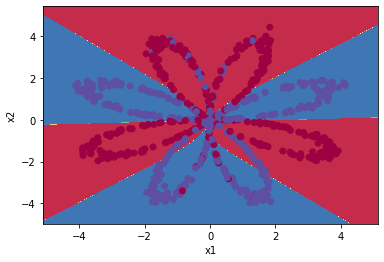

In [581]:
print("Decision Boundary for train, hidden layer size " + str(network.params['w1'].shape[0]))
plot_decision_boundary(lambda x: network(x)>0.5, X_train, y_train)

Decision Boundary for test, hidden layer size 3


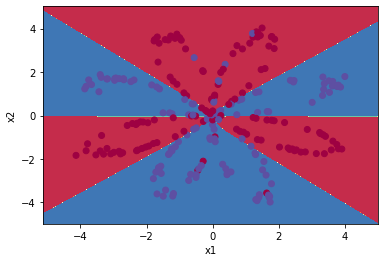

In [463]:
print("Decision Boundary for test, hidden layer size " + str(network.params['w1'].shape[0]))
plot_decision_boundary(lambda x: network(x)>0.5, X_test, y_test)